# CS5446 Warehouse Robot

In [1]:
from rddl_utils import (
    summarize_file, pretty_domain, pretty_instance, pretty_nonfluents, print_state_action_overview,
    read_text
)
from grid_planning import (
    build_grid, plot_grid, astar, path_to_actions, plot_path, plot_staged_path,
    single_agent_demo, multi_agent_demo, auto_pick_starts_goals,
    multi_agent_sequential, plot_multiple_paths_pretty_offset, evaluate_multi_agent,
    plot_routes_unified, animate_routes_unified_gif, path_length
)
from pickplace_utils import (
    parse_pick_drop_from_nonfluent_text, parse_start_from_instance_text, validate_or_fallback,
    plan_pick_and_drop, plot_pickdrop_offset, animate_pickdrop_gif_offset,
    plot_pickdrop_offset_smooth, animate_pickdrop_smooth_gif, astar_with_footprint,
    plot_explored_heatmap, plot_heuristic_field
)
from custom_layouts import make_enhanced_nonfl, ascii_preview
from experiments_3ab import (
    run_3a_3b, sample_zone_tasks, summary_compare, conflict_timeline, plot_conflict_timeline,
    plot_wait_gantt, plot_constraint_timeline, list_conflicts
)
from cbs_planner import run_cbs, CBSSearchError


In [2]:
FILENAMES = {
    'domain': 'warehouse_domain_formal.rddl',
    'instance': 'warehouse_instance_6x6_formal.rddl',
    'nonfl_clear': 'warehouse_nonfluents_6x6_clear_formal.rddl',
    'nonfl_shelf': 'warehouse_nonfluents_6x6_shelves_formal.rddl',
}

NEW_FILES = {
    'domain': 'warehouse_pickplace_domain.rddl',
    'nonfl': 'warehouse_pickplace_nonfluents_15x10.rddl',
    'instance': 'warehouse_pickplace_instance_15x10.rddl',
}


In [3]:
kind_dom, dom = summarize_file(FILENAMES['domain'])
kind_inst, inst = summarize_file(FILENAMES['instance'])
kind_clr, nfl_clear = summarize_file(FILENAMES['nonfl_clear'])
kind_shf, nfl_shelf = summarize_file(FILENAMES['nonfl_shelf'])

print('='*80); print('[Domain]'); print('='*80)
pretty_domain(dom)

print('='*80); print('[Instance]'); print('='*80)
pretty_instance(inst)

print('='*80); print('[Non-fluents] CLEAR'); print('='*80)
pretty_nonfluents(nfl_clear, 'CLEAR')

print('='*80); print('[Non-fluents] SHELVES'); print('='*80)
pretty_nonfluents(nfl_shelf, 'SHELVES')

print_state_action_overview(dom, nfl_clear, 'CLEAR')
print_state_action_overview(dom, nfl_shelf, 'SHELVES')


[Domain]
Domain name: warehouse_grid_mdp
Types: pos
State fluents (2): ['agent_x', 'agent_y']
Action fluents (4): ['move_east', 'move_north', 'move_south', 'move_west']
Has reward: True | CPFs (rough count): 2
[Instance]
Instance name: warehouse_inst_6x6
Domain ref: warehouse_grid_mdp
Non-fluents ref: warehouse_6x6_shelves
Horizon: 200  Discount: 1.0  MaxNondefActions: 1
Init-state:
  - agent_x = 0
  - agent_y = 0
Parsed start (agent_x, agent_y): (0, 0)
[Non-fluents] CLEAR
Non-fluents name: warehouse_6x6_clear (CLEAR)
Domain ref: warehouse_grid_mdp
Objects:
  - pos: {0..5
H x W = 6 x 6 | Goal = (5, 5)
Obstacles: 0
[Non-fluents] SHELVES
Non-fluents name: warehouse_6x6_shelves (SHELVES)
Domain ref: warehouse_grid_mdp
Objects:
  - pos: {0..5
H x W = 6 x 6 | Goal = (5, 5)
Obstacles: 12
Sample obstacles (first 10): [(1, 0), (1, 1), (1, 3), (1, 4), (2, 4), (3, 1), (3, 2), (3, 4), (5, 1), (5, 2)]

--------------------------------------------------------------------------------
[State & Action

Start (from instance): (0, 0)
Goal (CLEAR): (5, 5)
Goal (SHELVES): (5, 5)


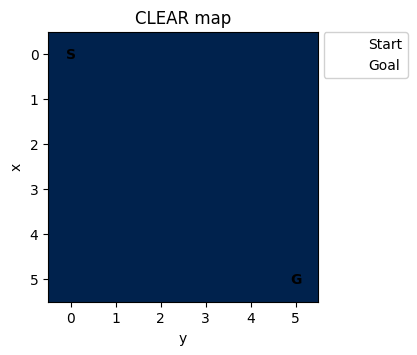

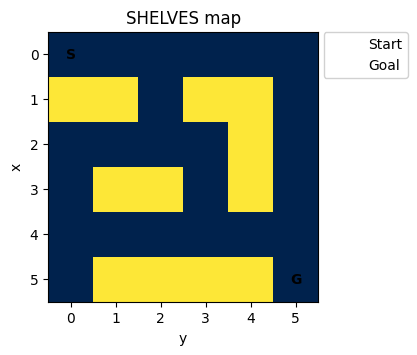

In [4]:
start_xy = inst.get('init_agent_xy')
print('Start (from instance):', start_xy)
print('Goal (CLEAR):', (nfl_clear.get('GOAL_X'), nfl_clear.get('GOAL_Y')))
print('Goal (SHELVES):', (nfl_shelf.get('GOAL_X'), nfl_shelf.get('GOAL_Y')))
plot_grid(nfl_clear, start_xy, title='CLEAR map')
plot_grid(nfl_shelf, start_xy, title='SHELVES map')


=== CLEAR map ===
[Single-agent]
start: (0, 0) goal: (5, 5) path_len: 10
actions: ['E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'S', 'S']


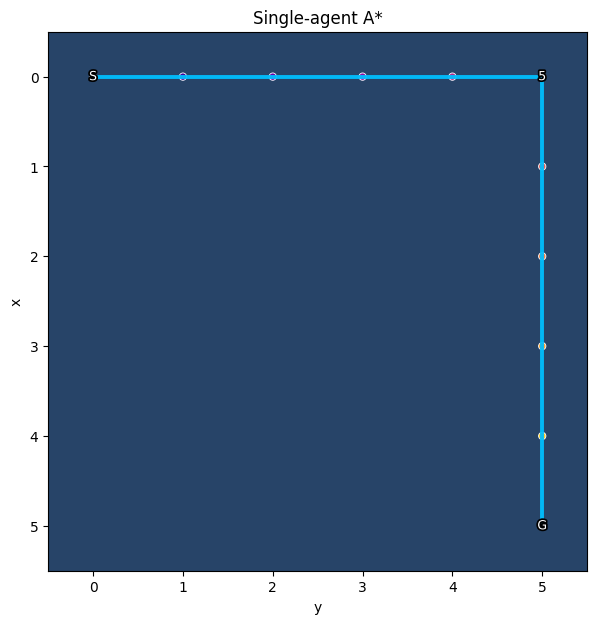

=== SHELVES map ===
[Single-agent]
start: (0, 0) goal: (5, 5) path_len: 10
actions: ['E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'S', 'S']


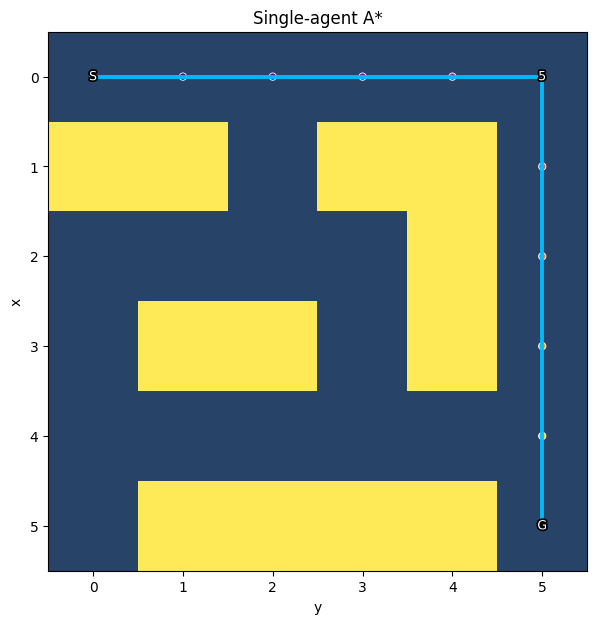

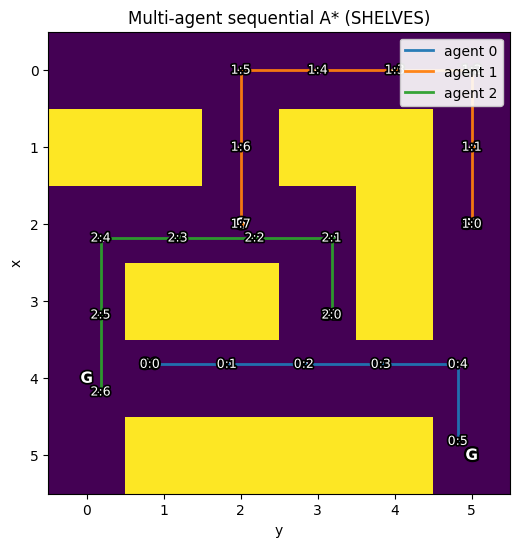

Multi-agent metrics: {'avg_len': 6.0, 'success_rate': 1.0, 'vertex_conflicts': 0, 'lengths': [5, 7, 6], 'successes': [True, True, True]}


In [5]:
print('=== CLEAR map ===')
single_agent_demo(nfl_clear, inst)

print('=== SHELVES map ===')
single_agent_demo(nfl_shelf, inst)

grid_sh = build_grid(nfl_shelf)
starts, goals = auto_pick_starts_goals(nfl_shelf, k=3, seed=13)
plans = multi_agent_sequential(grid_sh, starts, goals, t_max=256)
plot_multiple_paths_pretty_offset(nfl_shelf, plans, starts=starts, goals=goals, title='Multi-agent sequential A* (SHELVES)')
metrics = evaluate_multi_agent(grid_sh, starts, goals, plans)
print('Multi-agent metrics:', metrics)


In [6]:
# kind_d2, dom2 = summarize_file(NEW_FILES['domain'])
# kind_nf2, nf2 = summarize_file(NEW_FILES['nonfl'])
# kind_ins2, ins2 = summarize_file(NEW_FILES['instance'])

# print('='*80); print('[Pick&Place Domain]'); print('='*80)
# pretty_domain(dom2)

# print('='*80); print('[Pick&Place Non-fluents]'); print('='*80)
# pretty_nonfluents(nf2, 'Pick&Place')

# print('='*80); print('[Pick&Place Instance]'); print('='*80)
# pretty_instance(ins2)

# print_state_action_overview(dom2, nf2, '15x10 pick&place')
# plot_grid(nf2, start_xy=ins2.get('init_agent_xy'), title='Pick&Place 15x10 map')


In [7]:
# nf_text = read_text(NEW_FILES['nonfl'])
# ins_text = read_text(NEW_FILES['instance'])
# start_xy = parse_start_from_instance_text(ins_text) or ins2.get('init_agent_xy')
# start_xy = validate_or_fallback(nf2, start_xy)
# pick_set, drop_set = parse_pick_drop_from_nonfluent_text(nf_text)
# if not pick_set:
#     pick_set = [start_xy]
# if not drop_set:
#     drop_set = [pick_set[0]]
# pick_xy, drop_xy = pick_set[0], drop_set[0]
# pick_xy = validate_or_fallback(nf2, pick_xy)
# drop_xy = validate_or_fallback(nf2, drop_xy)
# print(f'[Pick&Place] start={start_xy}, pick={pick_xy}, drop={drop_xy}')
# p1, p2 = plan_pick_and_drop(nf2, start_xy, pick_xy, drop_xy)
# print('Phase-1 length:', None if p1 is None else len(p1)-1)
# print('Phase-2 length:', None if p2 is None else len(p2)-1)
# plot_pickdrop_offset(nf2, p1, p2, start_xy, pick_xy, drop_xy, title='Pick&Place S→P→D (offset)')
# plot_pickdrop_offset_smooth(nf2, p1, p2, start_xy, pick_xy, drop_xy, title='Pick&Place (smooth+offset)')

# # animate_pickdrop_gif_offset(nf2, p1, p2, start_xy, pick_xy, drop_xy, out_gif='pickplace_15x10_offset.gif')
# # animate_pickdrop_smooth_gif(nf2, p1, p2, start_xy, pick_xy, drop_xy, out_gif='pickplace_15x10_smooth.gif')


In [8]:
# grid = build_grid(nf2)
# p1_fp, fp1 = astar_with_footprint(grid, start_xy, pick_xy)
# p2_fp, fp2 = astar_with_footprint(grid, pick_xy, drop_xy)
# plot_explored_heatmap(nf2, fp1, title='A* explored heatmap (S→P)')
# plot_explored_heatmap(nf2, fp2, title='A* explored heatmap (P→D)')
# plot_heuristic_field(nf2, fp1, field='h')
# plot_heuristic_field(nf2, fp1, field='f')


Legend: .=free, #=shelf, I=inbound, O=outbound, P=packing, C=charging, >=one_way_east, <=one_way_west, ^=one_way_north, v=one_way_south
00 . I I . . . . . . . . . . . .
01 . . . . O > > . . O O . . . .
02 . O # . # . # O . # # ^ . # O
03 . . . . . . . . . . . ^ . . .
04 . P P . # O . . . O # . . . .
05 . . . v . . . . . . . O . . .
06 . O # v # . # O . # # # . # O
07 . . . . O . . . . O O . . . .
08 . . . . . < < . . . . . . C .
09 . . . . . . . . . . . . . . .


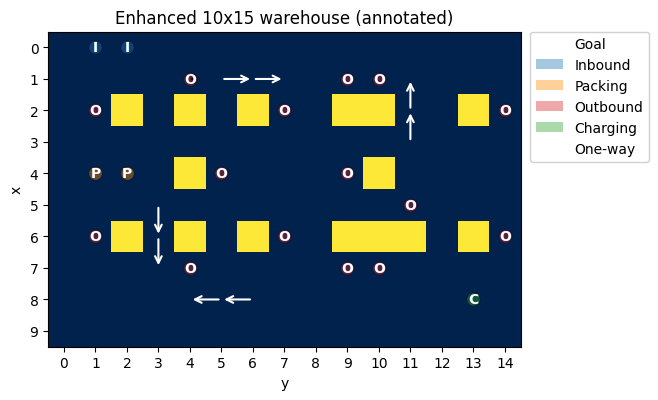

In [9]:
# Enhanced layout visualization with semantic annotations
print(ascii_preview())
enhanced_nonfl = make_enhanced_nonfl()
plot_grid(enhanced_nonfl, title='Enhanced 10x15 warehouse (annotated)', annotate_special=True, figsize=(7,7))

Sequential summary:
{'job': 'Job A', 'start': (0, 1), 'pick': (4, 1), 'drop': (1, 4), 'segments': (4, 6), 'total': 10}
{'job': 'Job B', 'start': (1, 4), 'pick': (4, 2), 'drop': (7, 10), 'segments': (5, 11), 'total': 16}
{'job': 'Job C', 'start': (7, 10), 'pick': (4, 2), 'drop': (4, 9), 'segments': (11, 9), 'total': 20}


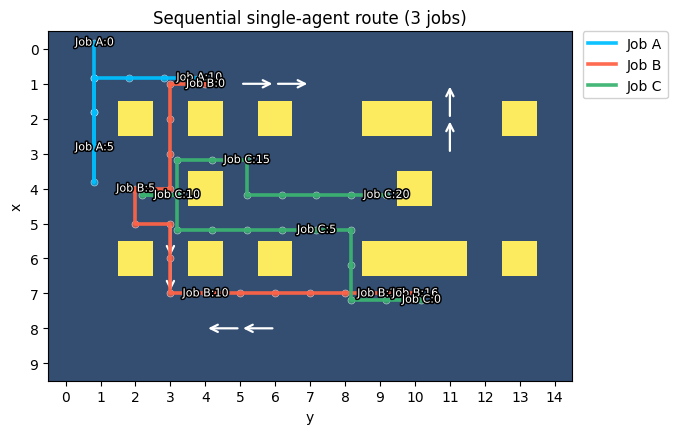


=== Job A ===
Start (0, 1) -> Pick (4, 1) -> Drop (1, 4)


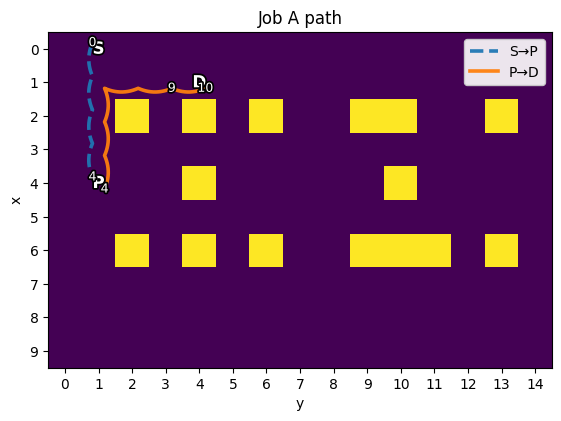

Saved GIF to: sequential_1.gif


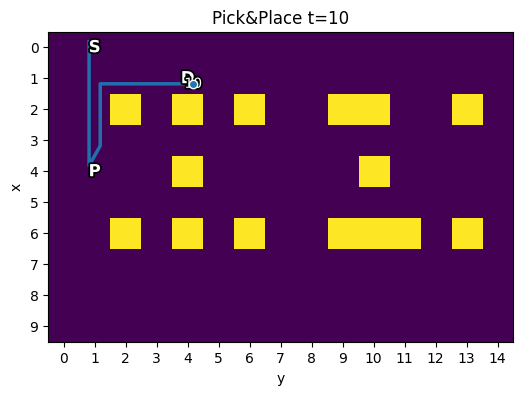

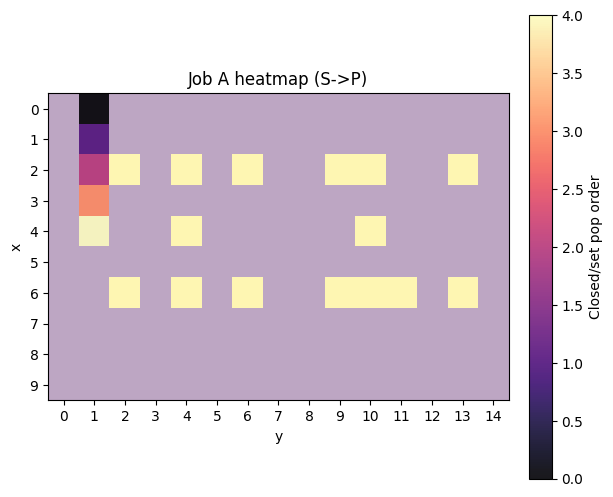

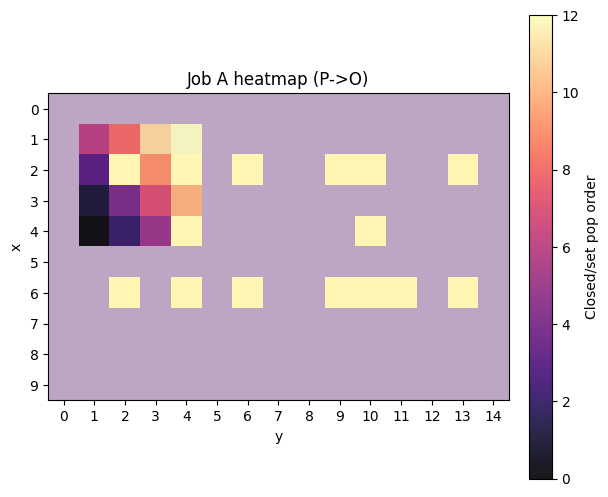


=== Job B ===
Start (1, 4) -> Pick (4, 2) -> Drop (7, 10)


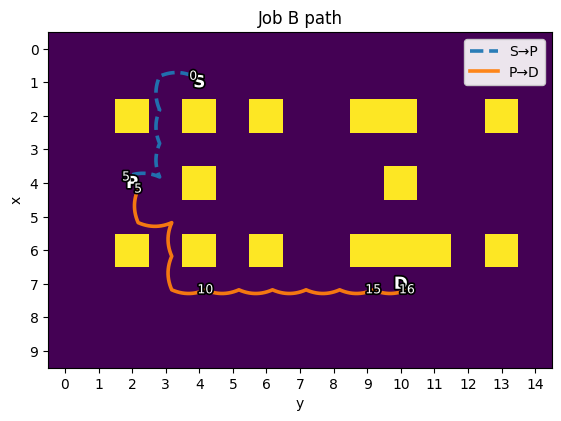

Saved GIF to: sequential_2.gif


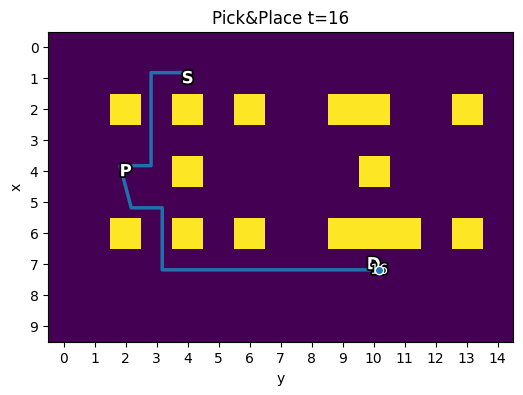

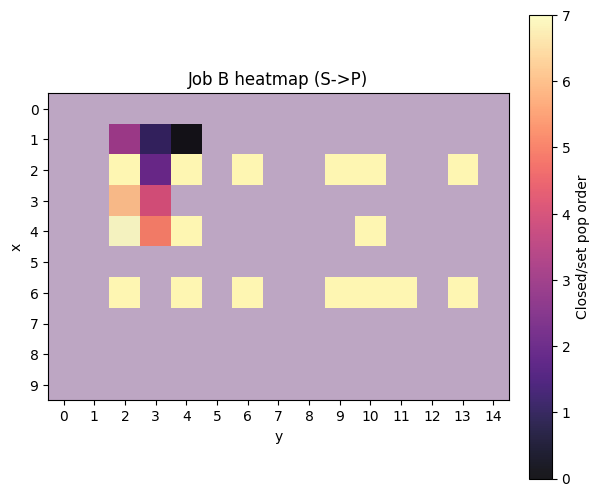

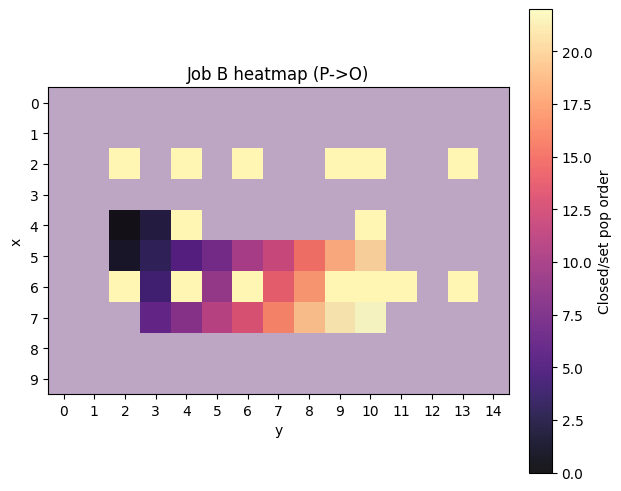


=== Job C ===
Start (7, 10) -> Pick (4, 2) -> Drop (4, 9)


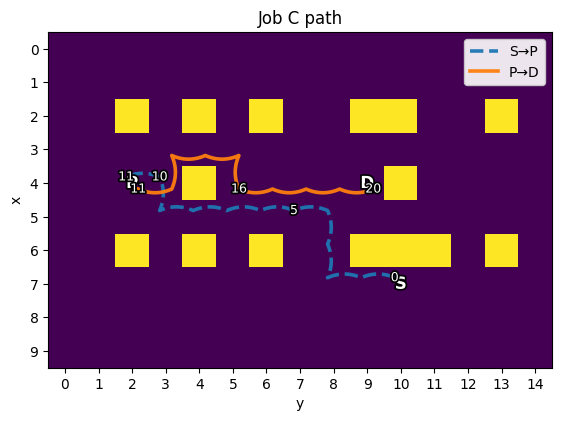

Saved GIF to: sequential_3.gif


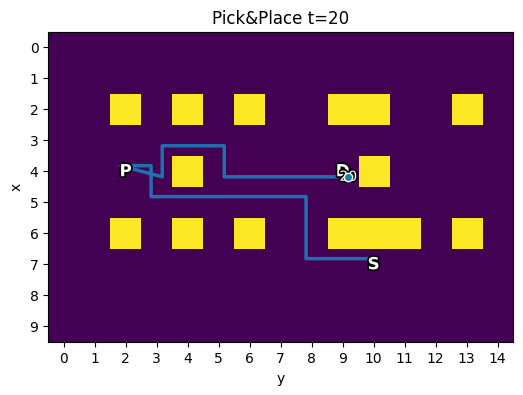

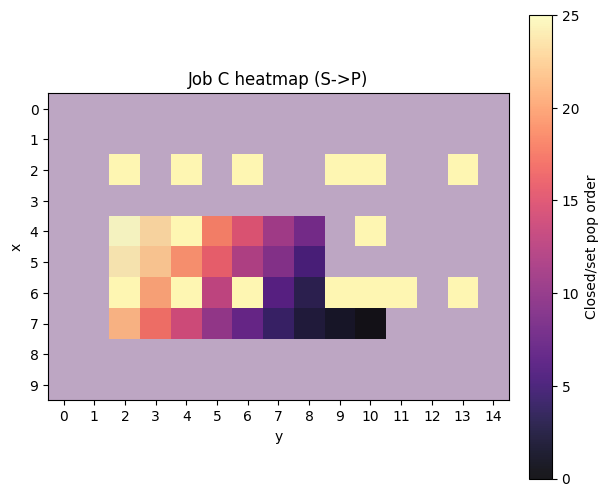

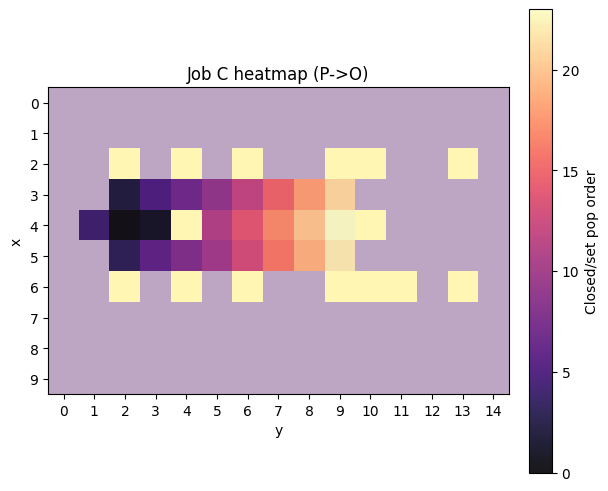

In [10]:
# Sequential execution: agent completes 3 tasks in one run
enhanced_nonfl = make_enhanced_nonfl()
grid = build_grid(enhanced_nonfl)
zones = enhanced_nonfl.get('zones', {})
inbounds = zones.get('inbound', [])
packings = zones.get('packing', [])
outbounds = zones.get('outbound', [])
jobs = [
    {'name': 'Job A', 'pick': packings[0], 'drop': outbounds[0]},
    {'name': 'Job B', 'pick': packings[-1], 'drop': outbounds[-1]},
    {'name': 'Job C', 'pick': packings[min(1, len(packings)-1)], 'drop': outbounds[len(outbounds)//2]},
]
current_pos = inbounds[0]
full_path = [current_pos]
job_records = []
summary = []
for job in jobs:
    pick, drop = job['pick'], job['drop']
    path_sp, fp_sp = astar_with_footprint(grid, current_pos, pick)
    if path_sp is None:
        raise RuntimeError(f"No path {current_pos}->{pick}")
    path_pd, fp_pd = astar_with_footprint(grid, pick, drop)
    if path_pd is None:
        raise RuntimeError(f"No path {pick}->{drop}")
    full_path.extend(path_sp[1:])
    full_path.extend(path_pd[1:])
    seg1 = len(path_sp) - 1
    seg2 = len(path_pd) - 1
    summary.append({'job': job['name'], 'start': current_pos, 'pick': pick, 'drop': drop, 'segments': (seg1, seg2), 'total': seg1 + seg2})
    job_records.append({
        'job': job['name'],
        'start': current_pos,
        'pick': pick,
        'drop': drop,
        'path_sp': path_sp,
        'path_pd': path_pd,
        'fp_sp': fp_sp,
        'fp_pd': fp_pd,
    })
    current_pos = drop

print('Sequential summary:')
for row in summary:
    print(row)

colors = ['deepskyblue', 'tomato', 'mediumseagreen']
offsets = [(-0.18, -0.18), (0.0, 0.0), (0.18, 0.18)]
segments = []
for idx, rec in enumerate(job_records):
    combined = rec['path_sp'] + rec['path_pd'][1:]
    segments.append({
        'label': rec['job'],
        'path': combined,
        'color': colors[idx % len(colors)],
        'offset': offsets[idx % len(offsets)],
    })

plot_staged_path(
    enhanced_nonfl,
    segments,
    title='Sequential single-agent route (3 jobs)',
    annotate_every=5
)

for idx, rec in enumerate(job_records, 1):
    print(f"\n=== {rec['job']} ===")
    print(f"Start {rec['start']} -> Pick {rec['pick']} -> Drop {rec['drop']}")
    plot_pickdrop_offset_smooth(
        enhanced_nonfl,
        rec['path_sp'],
        rec['path_pd'],
        start_xy=rec['start'],
        pick_xy=rec['pick'],
        drop_xy=rec['drop'],
        title=f"{rec['job']} path"
    )
    animate_pickdrop_gif_offset(
        enhanced_nonfl,
        rec['path_sp'],
        rec['path_pd'],
        start_xy=rec['start'],
        pick_xy=rec['pick'],
        drop_xy=rec['drop'],
        out_gif=f"sequential_{idx}.gif",
        fps=2
    )
    plot_explored_heatmap(enhanced_nonfl, rec['fp_sp'], title=f"{rec['job']} heatmap (S->P)")
    plot_explored_heatmap(enhanced_nonfl, rec['fp_pd'], title=f"{rec['job']} heatmap (P->O)")


Legend: .=free, #=shelf, I=inbound, O=outbound, P=packing, C=charging, >=one_way_east, <=one_way_west, ^=one_way_north, v=one_way_south
00 . I I . . . . . . . . . . . .
01 . . . . O > > . . O O . . . .
02 . O # . # . # O . # # ^ . # O
03 . . . . . . . . . . . ^ . . .
04 . P P . # O . . . O # . . . .
05 . . . v . . . . . . . O . . .
06 . O # v # . # O . # # # . # O
07 . . . . O . . . . O O . . . .
08 . . . . . < < . . . . . . C .
09 . . . . . . . . . . . . . . .
[Setup]
agents: 3 seed: 13
starts: [(0, 1), (0, 2), (0, 1)]
goals: [(4, 9), (5, 11), (1, 4)]

[3A Naive]
success_rate: 1.0
avg_len: 13.333333333333334
vertex_conflicts: 5
edge_conflicts: 0

[3B Prioritized]
success_rate: 1.0
avg_len: 14.0
vertex_conflicts: 1
edge_conflicts: 0


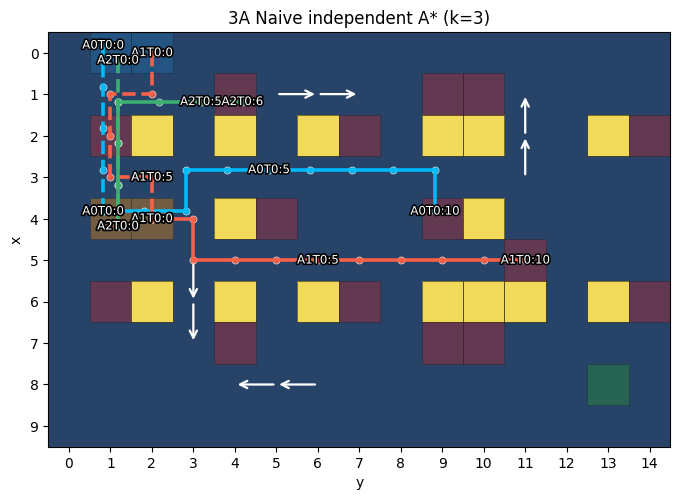

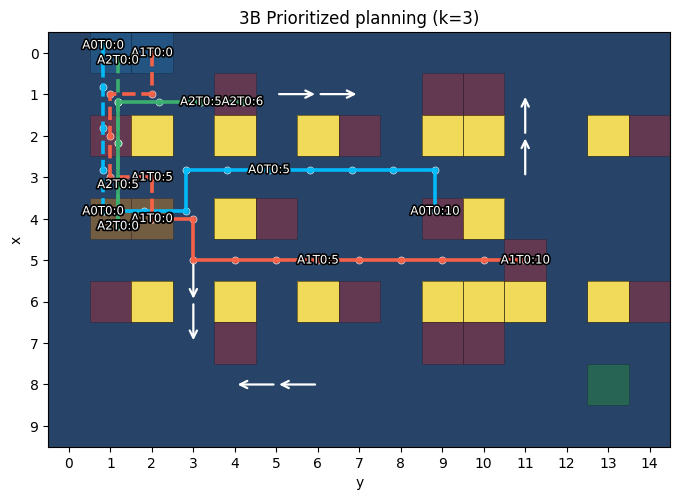


=== Summary ===
Naive: {'avg_len': 13.333333333333334, 'success_rate': 1.0, 'vertex_conflicts': 5, 'lengths': [14, 16, 10], 'successes': [True, True, True], 'edge_conflicts': 0}
Prioritized: {'avg_len': 14.0, 'success_rate': 1.0, 'vertex_conflicts': 1, 'lengths': [14, 16, 12], 'successes': [True, True, True], 'edge_conflicts': 0}


In [11]:
# === MAPF Step 3A/3B Experiment (append) ===
from custom_layouts import make_enhanced_nonfl, ascii_preview
from experiments_3ab import run_3a_3b

# Use enhanced 10x15 environment; tweak inflation_radius to simulate wider robots
nonfl = make_enhanced_nonfl(inflation_radius=0)
print(ascii_preview())  # quick sanity check of the ASCII layout

# Run both variants on identical starts/goals
result = run_3a_3b(nonfl=nonfl, k_agents=3, seed=13, t_max=256, make_gif=False)

# Quick metrics glance
print("\n=== Summary ===")
print("Naive:", result["metrics_naive"])
print("Prioritized:", result["metrics_prioritized"])

Saved GIF to: naive_3A.gif
Saved GIF to: prioritized_3B.gif


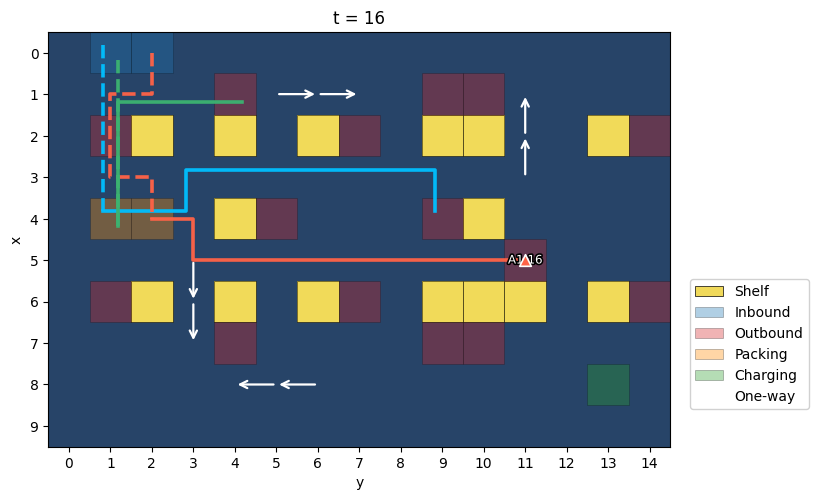

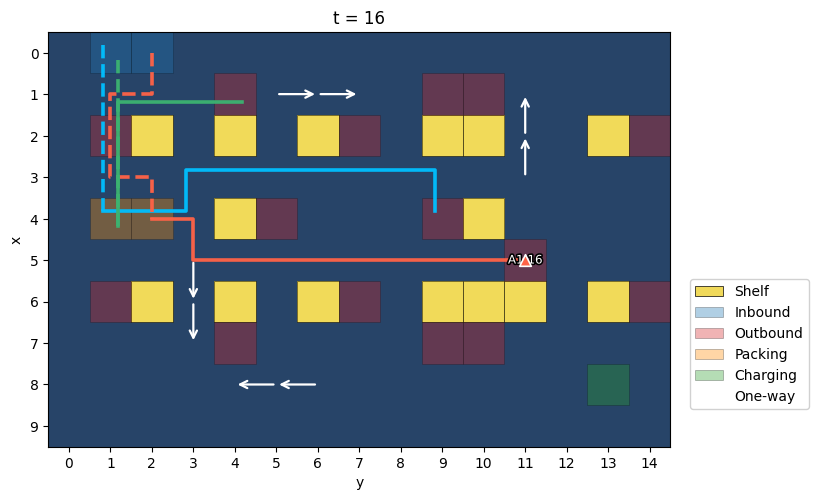

In [12]:
# === GIF export (unified visualization) ===
from grid_planning import animate_routes_unified_gif

# Naive
animate_routes_unified_gif(
    result["nonfl"],
    result["segments_naive"],    # 分段：每 agent [SP, PD]
    out_gif="naive_3A.gif",
    fps=2,
    annotate_every=5
)

# Prioritized
animate_routes_unified_gif(
    result["nonfl"],
    result["segments_prioritized"],
    out_gif="prioritized_3B.gif",
    fps=2,
    annotate_every=5
)

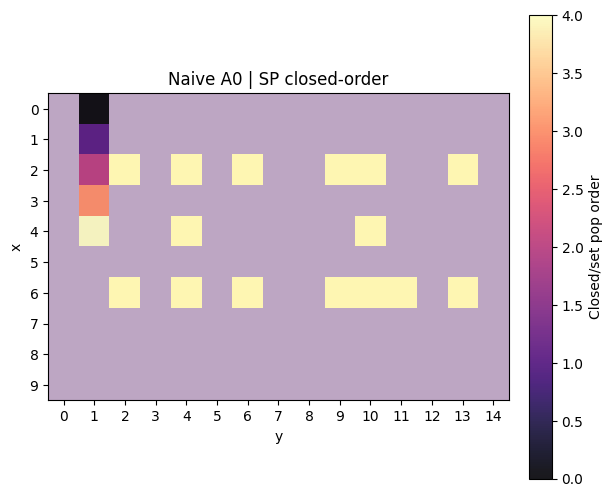

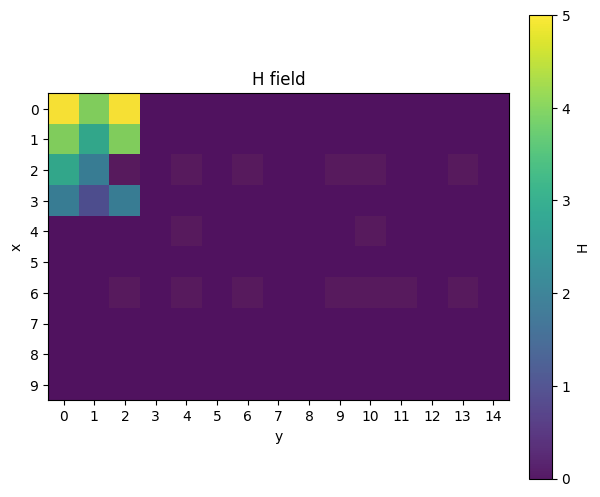

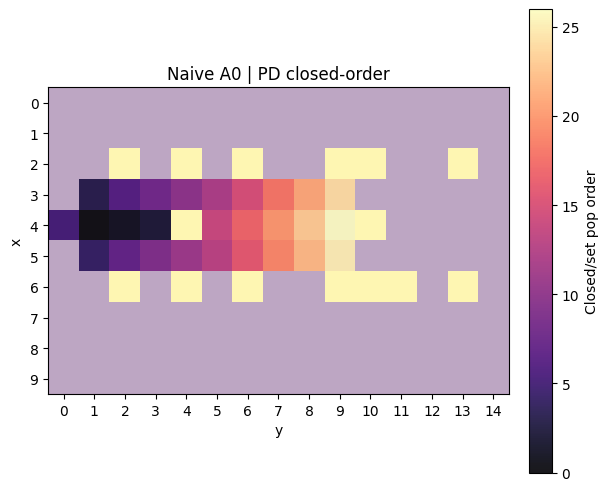

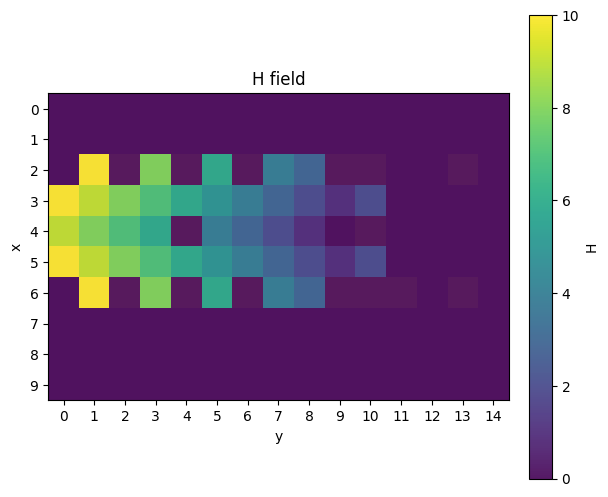

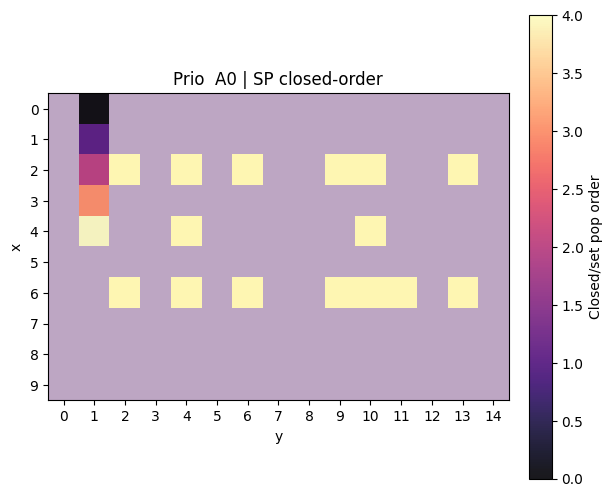

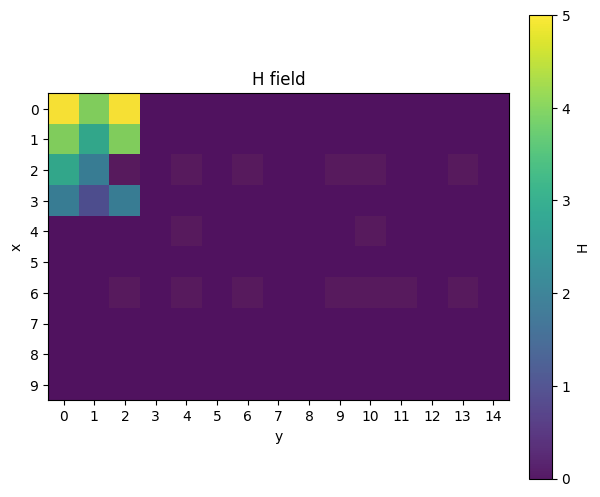

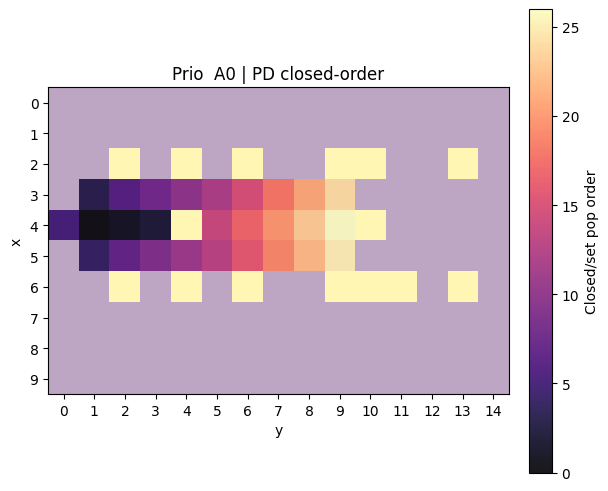

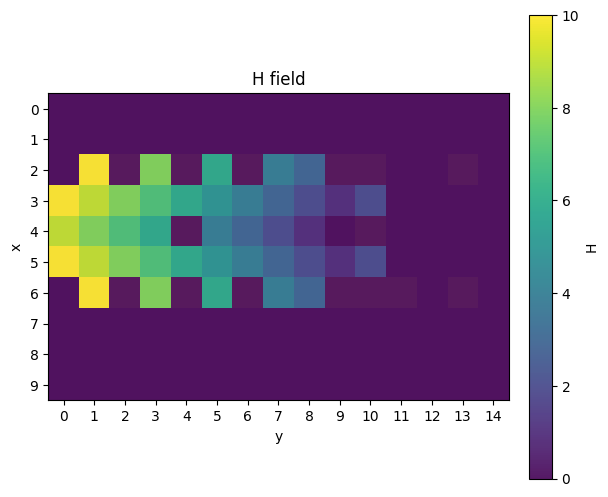

In [13]:
# === A* footprint & heuristic fields (append) ===
from grid_planning import build_grid
from pickplace_utils import astar_with_footprint, plot_explored_heatmap, plot_heuristic_field

# 替换 result 为 res 即可对 k=4 那组做同样可视化
nonfl_v = result["nonfl"]
grid_v  = build_grid(nonfl_v)

def viz_agent_segments(segments, agent_idx=0, title_prefix="Naive A"):
    # 找到 agent_idx 的两段
    segs = segments[agent_idx]
    sp = [s for s in segs if s.get("phase") == "SP"][0]
    pd = [s for s in segs if s.get("phase") == "PD"][0]

    # S->P
    s_xy, p_xy = sp["path"][0], sp["path"][-1]
    path_sp, fp_sp = astar_with_footprint(grid_v, s_xy, p_xy)
    plot_explored_heatmap(nonfl_v, fp_sp, title=f"{title_prefix}{agent_idx} | SP closed-order")
    plot_heuristic_field(nonfl_v, fp_sp, field="h")  # 可改 'f' 或 'g'

    # P->D
    p_xy2, d_xy = pd["path"][0], pd["path"][-1]
    path_pd, fp_pd = astar_with_footprint(grid_v, p_xy2, d_xy)
    plot_explored_heatmap(nonfl_v, fp_pd, title=f"{title_prefix}{agent_idx} | PD closed-order")
    plot_heuristic_field(nonfl_v, fp_pd, field="h")

# 分别可视化 Naive 与 Prioritized 的第0号agent
viz_agent_segments(result["segments_naive"], agent_idx=0, title_prefix="Naive A")
viz_agent_segments(result["segments_prioritized"], agent_idx=0, title_prefix="Prio  A")

In [14]:
# === Summary compare (append) ===
from grid_planning import path_length
from experiments_3ab import count_edge_conflicts

def waits_in_path(path):
    if not path: return 0
    w = 0
    for (x1,y1),(x2,y2) in zip(path, path[1:]):
        if (x1,y1)==(x2,y2): w += 1
    return w

def summarize(plans, name=""):
    lens = [path_length(p) or 0 for p in plans]
    soc  = sum(lens)
    mksp = max(lens) if lens else 0
    waits = sum(waits_in_path(p) for p in plans if p)
    return {
        "name": name,
        "SoC": soc,
        "Makespan": mksp,
        "AvgLen": (soc/len(lens)) if lens else 0,
        "VertexConflicts":  result["metrics_naive"]["vertex_conflicts"] if name=="Naive" else result["metrics_prioritized"]["vertex_conflicts"],
        "EdgeConflicts":    count_edge_conflicts(plans),
        "TotalWaits":       waits,
    }

cmp = [
    summarize(result["plans_naive"], "Naive"),
    summarize(result["plans_prioritized"], "Prioritized"),
]

print("=== Compare (k=3) ===")
for row in cmp: print(row)



=== Compare (k=3) ===
{'name': 'Naive', 'SoC': 40, 'Makespan': 16, 'AvgLen': 13.333333333333334, 'VertexConflicts': 5, 'EdgeConflicts': 0, 'TotalWaits': 0}
{'name': 'Prioritized', 'SoC': 42, 'Makespan': 16, 'AvgLen': 14.0, 'VertexConflicts': 1, 'EdgeConflicts': 0, 'TotalWaits': 2}


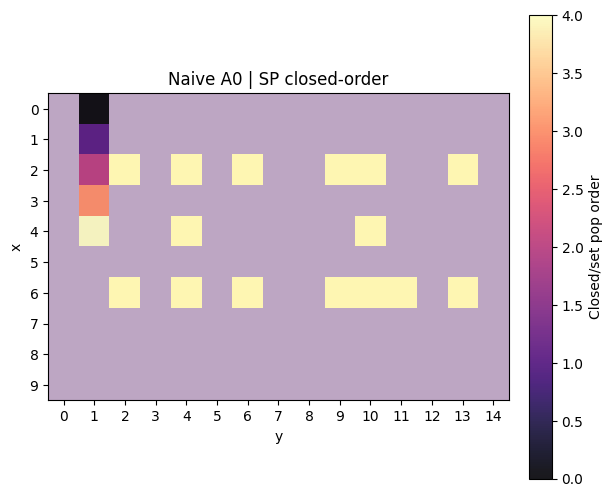

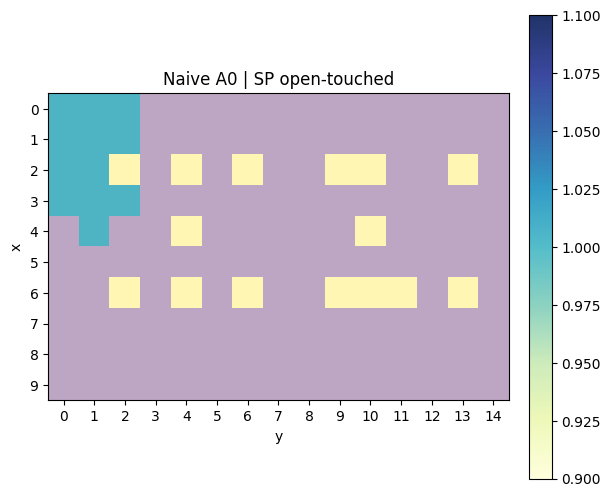

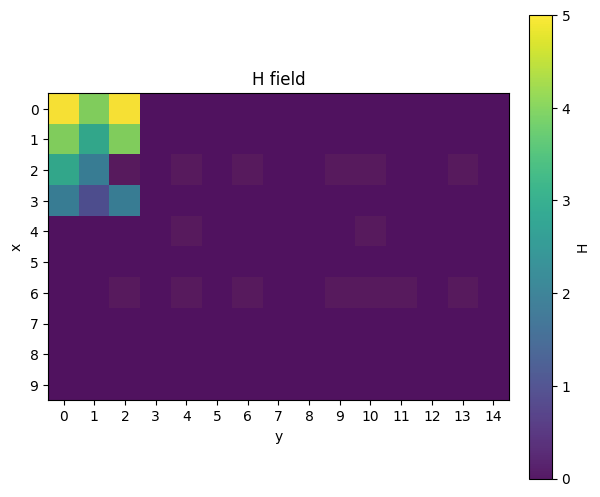

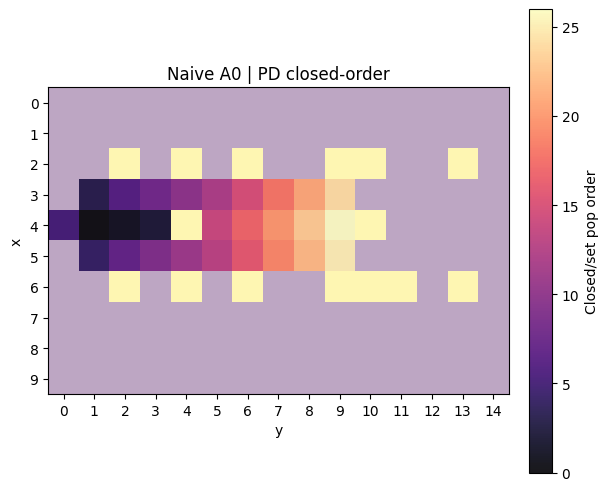

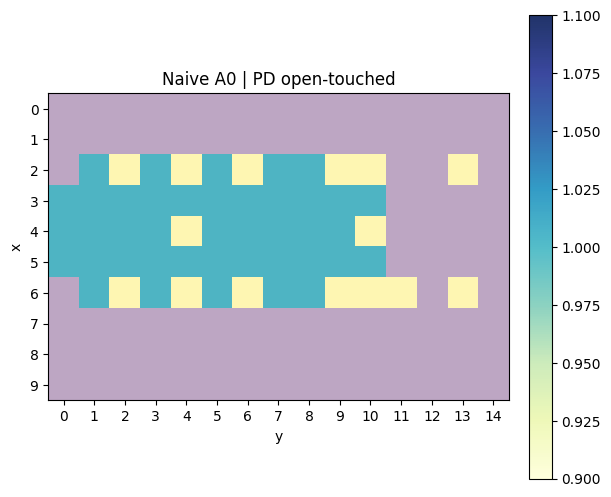

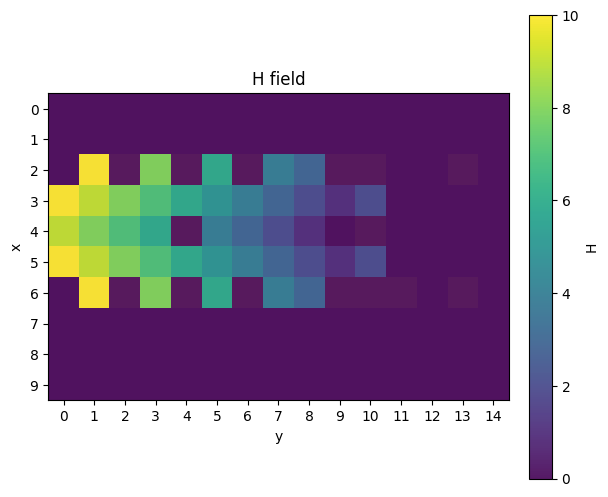

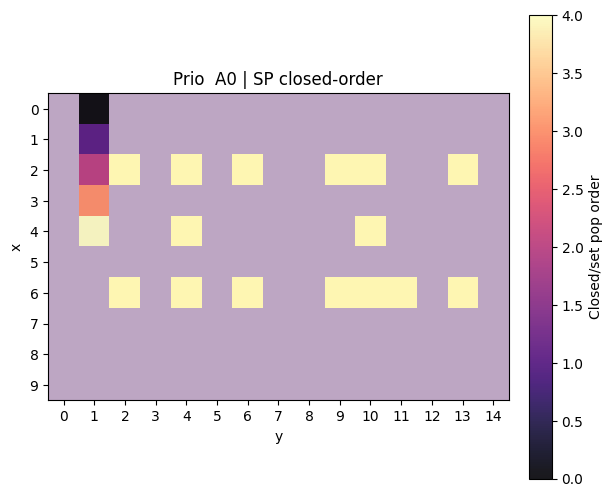

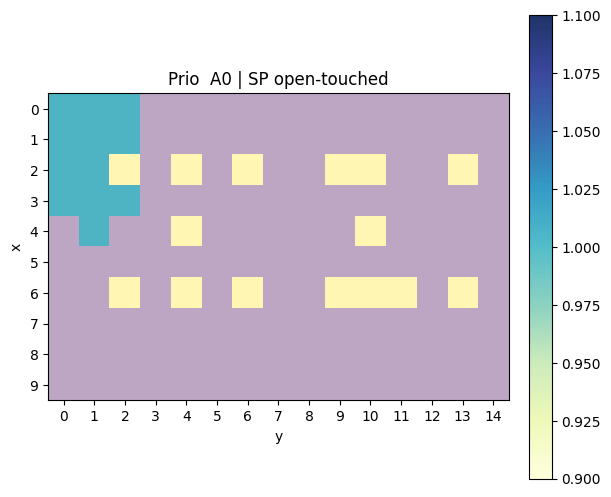

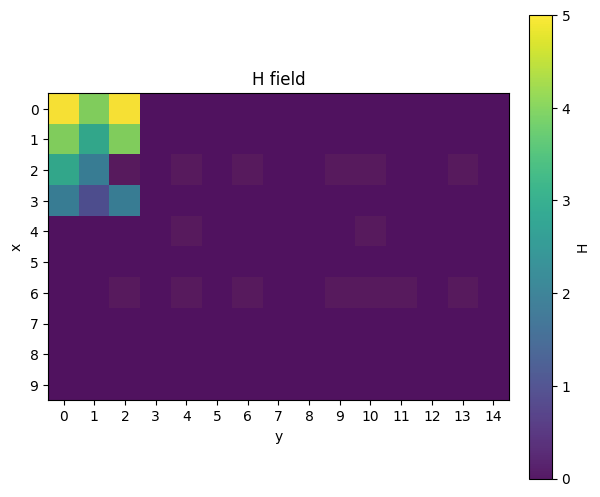

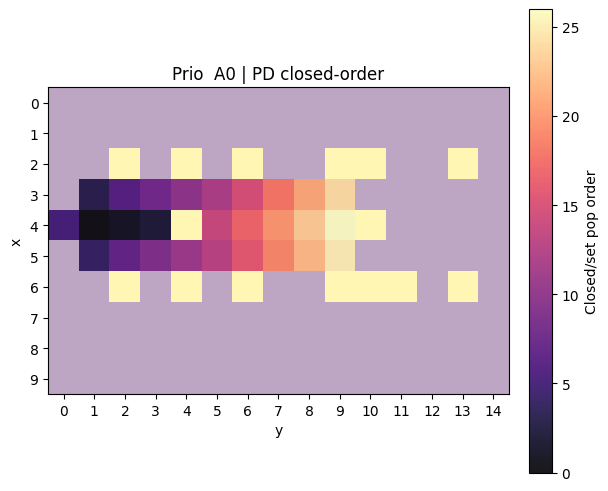

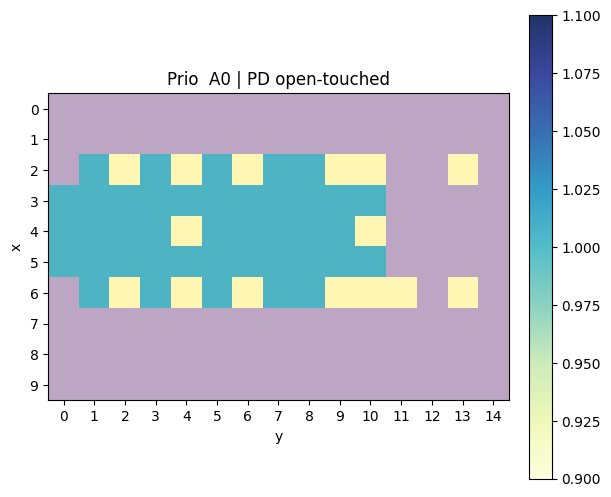

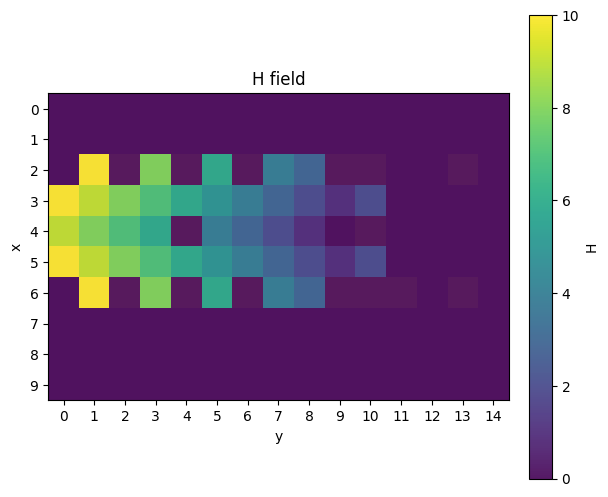

In [15]:
# === A* fields: closed-order / open-touched / h (append) ===
from experiments_3ab import analyze_astar_for_agent

# Naive 第0号 agent
analyze_astar_for_agent(result["nonfl"], result["segments_naive"], agent_idx=0, title_prefix="Naive A")

# Prioritized 第0号 agent
analyze_astar_for_agent(result["nonfl"], result["segments_prioritized"], agent_idx=0, title_prefix="Prio  A")

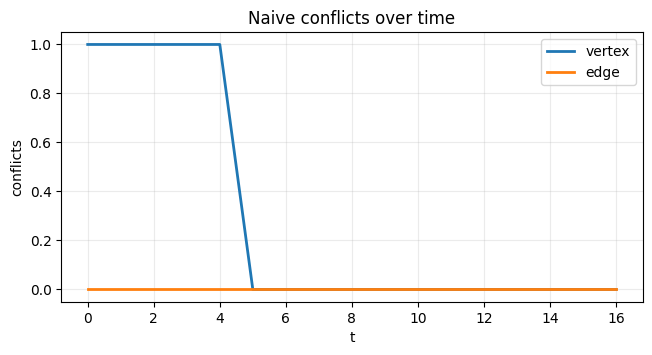

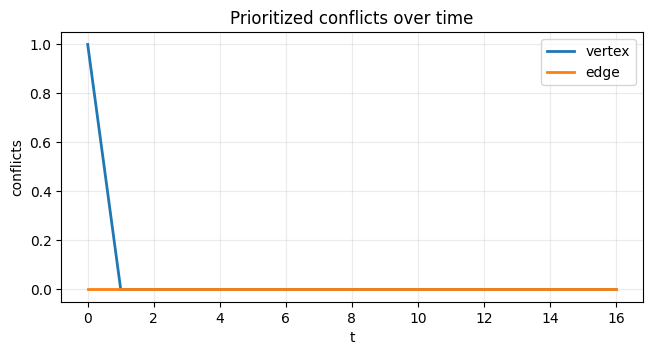

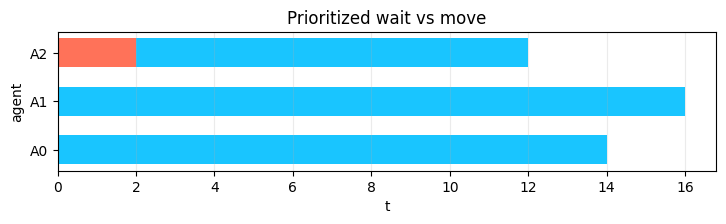

In [16]:
# === Conflict timeline + Wait Gantt (append) ===
from experiments_3ab import conflict_timeline, plot_conflict_timeline, plot_wait_gantt

# 冲突时间线
tl_naive = conflict_timeline(result["plans_naive"])
plot_conflict_timeline(tl_naive, title="Naive conflicts over time")

tl_prio = conflict_timeline(result["plans_prioritized"])
plot_conflict_timeline(tl_prio, title="Prioritized conflicts over time")

# 等待甘特（优先级方案更有意义）
plot_wait_gantt(result["plans_prioritized"], title="Prioritized wait vs move")

In [17]:
# === Summary compare (append) ===
from experiments_3ab import summary_compare

cmp = summary_compare(result)
print("=== Compare (k=3) ===")
for k,v in cmp.items():
    print(k, v)

=== Compare (k=3) ===
Naive {'SoC': 40, 'Makespan': 16, 'AvgLen': 13.333333333333334, 'VertexConflicts': 5, 'EdgeConflicts': 0, 'TotalWaits': 0, 'SuccessRate': 1.0}
Prioritized {'SoC': 42, 'Makespan': 16, 'AvgLen': 14.0, 'VertexConflicts': 1, 'EdgeConflicts': 0, 'TotalWaits': 2, 'SuccessRate': 1.0}


[CBS] Success with seed 29 after 1 attempt(s).
CBS tasks (S,P,D per agent): [((0, 2), (4, 1), (1, 10)), ((0, 1), (4, 2), (4, 9)), ((0, 2), (4, 1), (6, 7))]
CBS cost (SoC): 44
CBS stats: {'expanded': 1, 'generated': 3}
Agent path lengths: [17, 14, 13] | makespan = 17


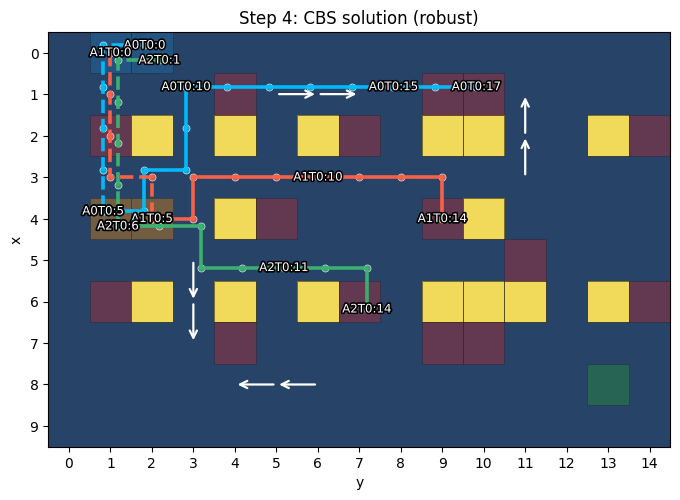

Saved GIF to: step4_cbs.gif


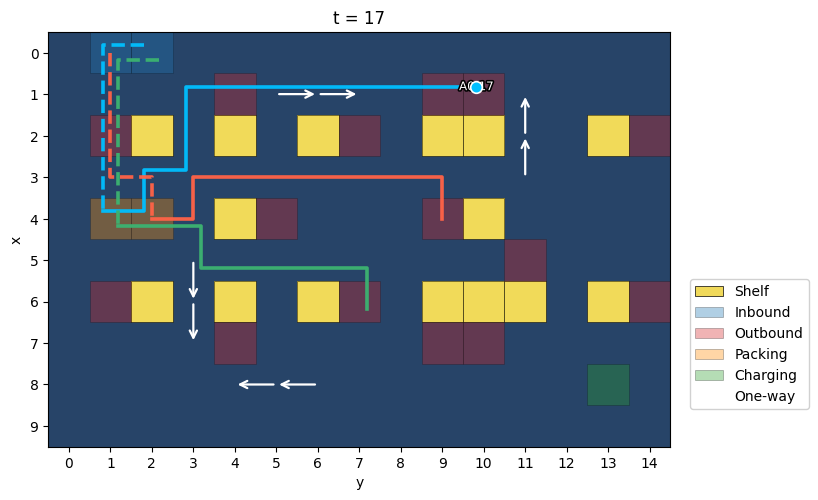

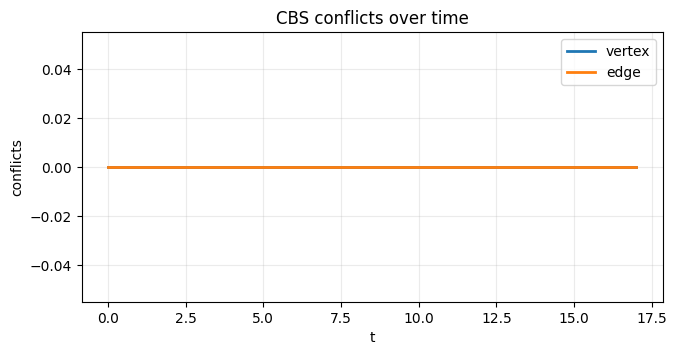

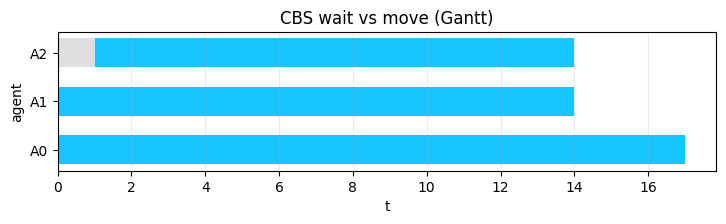

In [18]:
# Step 4: Conflict-Based Search (CBS) baseline
enhanced_nonfl = make_enhanced_nonfl()
attempts = 8
tasks_cbs = None
cbs_result = None
for i in range(attempts):
    seed = 29 + i
    candidate_tasks = sample_zone_tasks(enhanced_nonfl, k=3, seed=seed)
    try:
        candidate_result = run_cbs(
            candidate_tasks,
            nonfl=enhanced_nonfl,
            t_max=256,
            cost_metric='soc',
            max_expansions=40000,
            verbose=False
        )
        tasks_cbs = candidate_tasks
        cbs_result = candidate_result
        print(f'[CBS] Success with seed {seed} after {i+1} attempt(s).')
        break
    except CBSSearchError as exc:
        log_tail = exc.stats.get('log_tail', [])
        print(f'[CBS] Attempt {i+1} failed (seed {seed}): {exc}')
        if log_tail:
            print('--- CBS debug log (tail) ---')
            for line in log_tail:
                print(line)
        if exc.best_result:
            print('[CBS] Using best partial solution for visualization (may still have conflicts).')
            tasks_cbs = candidate_tasks
            cbs_result = exc.best_result
            break
if cbs_result is None:
    raise RuntimeError('CBS could not find a solution across attempted seeds.')

print('CBS tasks (S,P,D per agent):', tasks_cbs)
print('CBS cost (SoC):', cbs_result['cost'])
print('CBS stats:', {k:v for k,v in cbs_result['stats'].items() if k!='log_tail'})
lengths = [path_length(p) for p in cbs_result['paths']]
valid_lengths = [l for l in lengths if l is not None]
makespan = max(valid_lengths) if valid_lengths else None
print('Agent path lengths:', lengths, '| makespan =', makespan)
plot_routes_unified(
    enhanced_nonfl,
    cbs_result['segments'],
    title='Step 4: CBS solution (robust)',
    annotate_every=5
)
animate_routes_unified_gif(
    enhanced_nonfl,
    cbs_result['segments'],
    out_gif='step4_cbs.gif',
    fps=1,
    annotate_every=5
)
timeline = conflict_timeline(cbs_result['paths'])
plot_conflict_timeline(timeline, title='CBS conflicts over time')
plot_wait_gantt(cbs_result['paths'], title='CBS wait vs move (Gantt)')


[CBS] Success with seed 29 after 1 attempt(s).
CBS tasks (S,P,D per agent): [((0, 2), (4, 1), (1, 10)), ((0, 1), (4, 2), (4, 9)), ((0, 2), (4, 1), (6, 7))]
CBS path (per agent):
=== Agent 0 ===
[(0, 2), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (3, 2), (3, 3), (2, 3), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)]
=== Agent 1 ===
[(0, 1), (1, 1), (2, 1), (3, 1), (3, 2), (4, 2), (4, 3), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 9)]
=== Agent 2 ===
[None, (0, 2), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (4, 3), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 7)]
CBS cost (SoC): 44
CBS stats: {'expanded': 1, 'generated': 3}
Agent path lengths: [17, 14, 13] | makespan = 17


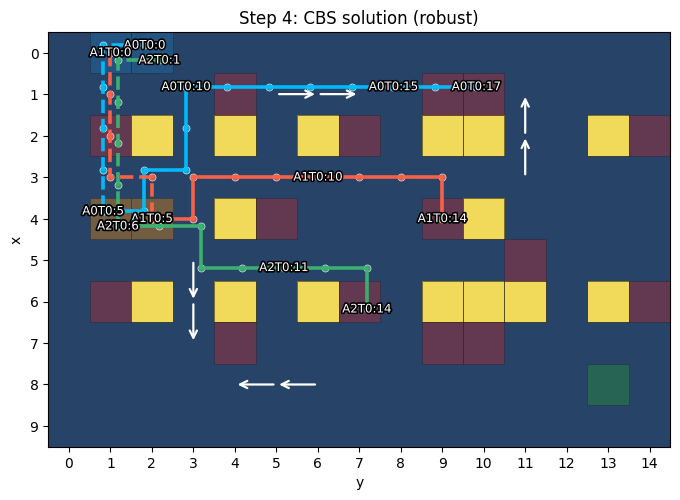

Saved GIF to: step4_cbs.gif


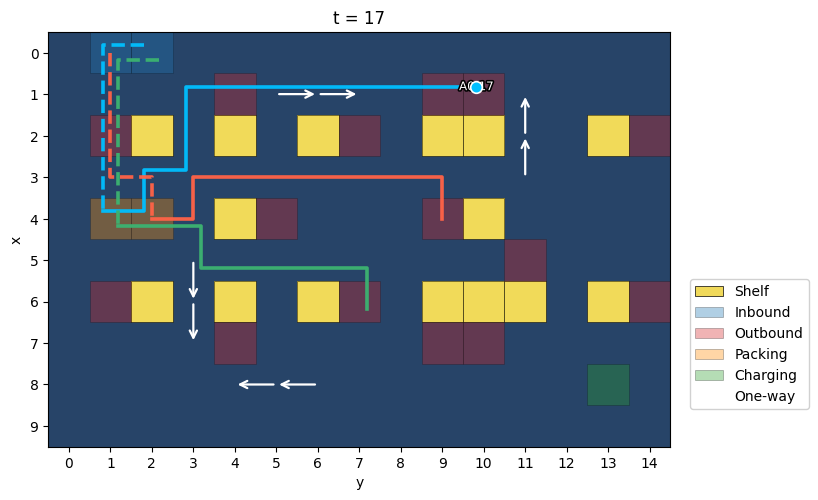

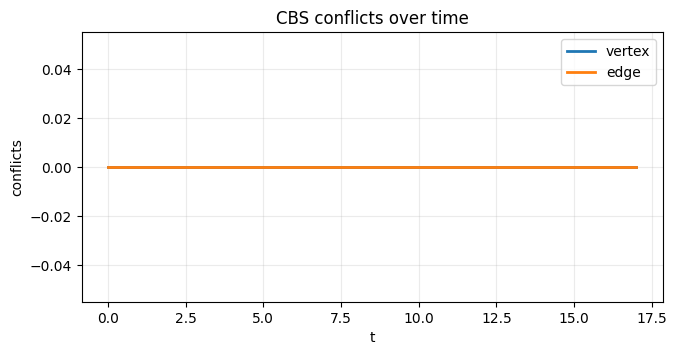

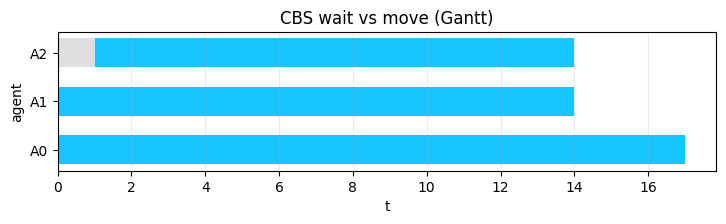

In [19]:
# Step 4: Conflict-Based Search (CBS) baseline
enhanced_nonfl = make_enhanced_nonfl()
attempts = 5
tasks_cbs = None
cbs_result = None
best_partial = None
best_partial_tasks = None
for i in range(attempts):
    seed = 29 + i
    candidate_tasks = sample_zone_tasks(enhanced_nonfl, k=3, seed=seed)
    try:
        candidate_result = run_cbs(
            candidate_tasks,
            nonfl=enhanced_nonfl,
            t_max=256,
            cost_metric='soc',
            max_expansions=20000,
            verbose=False
        )
        tasks_cbs = candidate_tasks
        cbs_result = candidate_result
        print(f'[CBS] Success with seed {seed} after {i+1} attempt(s).')
        break
    except CBSSearchError as exc:
        log_tail = exc.stats.get('log_tail', [])
        print(f'[CBS] Attempt {i+1} failed (seed {seed}): {exc}')
        if log_tail:
            print('--- CBS debug log (tail) ---')
            for line in log_tail:
                print(line)
        if exc.best_result and (best_partial is None or exc.best_result['cost'] < best_partial['cost']):
            best_partial = exc.best_result
            best_partial_tasks = candidate_tasks
if cbs_result is None:
    if best_partial is None:
        raise RuntimeError('CBS could not find a solution across attempted seeds.')
    print('[CBS] Using best partial solution for visualization (may still have conflicts).')
    cbs_result = best_partial
    tasks_cbs = best_partial_tasks
    timeline_partial = conflict_timeline(cbs_result['paths'])
    residual_vertex = max(timeline_partial['vertex']) if timeline_partial['vertex'] else 0
    residual_edge = max(timeline_partial['edge']) if timeline_partial['edge'] else 0
    print(f"Remaining conflicts: vertex={residual_vertex}, edge={residual_edge}")
    events = list_conflicts(cbs_result['paths'], limit=5)
    if events:
        print('Sample conflicts:')
        for ev in events:
            if ev['type'] == 'vertex':
                print(f"  vertex t={ev['time']} cell={ev['cell']} agents={ev['agents']}")
            else:
                print(f"  edge   t={ev['time']} edge={ev['edge']} agents={ev['agents']}")

print('CBS tasks (S,P,D per agent):', tasks_cbs)
print('CBS path (per agent):')
for i in range(len(cbs_result['paths'])):
  print(f"=== Agent {i} ===")
  print(cbs_result['paths'][i])
print('CBS cost (SoC):', cbs_result['cost'])
print('CBS stats:', {k:v for k,v in cbs_result['stats'].items() if k!='log_tail'})
lengths = [path_length(p) for p in cbs_result['paths']]
valid_lengths = [l for l in lengths if l is not None]
makespan = max(valid_lengths) if valid_lengths else None
print('Agent path lengths:', lengths, '| makespan =', makespan)
plot_routes_unified(
    enhanced_nonfl,
    cbs_result['segments'],
    title='Step 4: CBS solution (robust)',
    annotate_every=5
)
animate_routes_unified_gif(
    enhanced_nonfl,
    cbs_result['segments'],
    out_gif='step4_cbs.gif',
    fps=1,
    annotate_every=5
)
timeline = conflict_timeline(cbs_result['paths'])
plot_conflict_timeline(timeline, title='CBS conflicts over time')
plot_wait_gantt(cbs_result['paths'], title='CBS wait vs move (Gantt)')


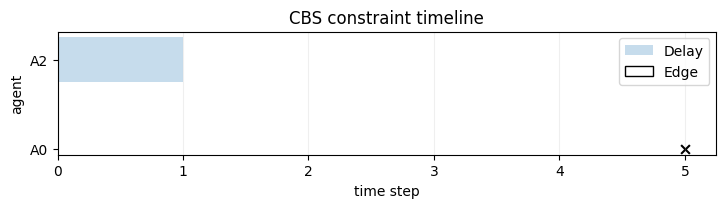

In [20]:
# Step 4: visualize CBS constraint timeline
plot_constraint_timeline(cbs_result.get('constraints', {}), title='CBS constraint timeline')


[CBS-multi] Success with seed 50 after 1 attempt(s).
Multi-stage CBS tasks (per agent):
  Agent 0: [((0, 1), (4, 1), (1, 10)), ((1, 10), (4, 1), (2, 14))]
  Agent 1: [((0, 2), (4, 2), (4, 5)), ((4, 5), (4, 2), (2, 1))]
  Agent 2: [((0, 1), (4, 1), (7, 4)), ((7, 4), (4, 1), (1, 9))]
=== Agent 0 ===
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (4, 3), (3, 3), (2, 3), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 9), (1, 8), (1, 7), (1, 6), (1, 5), (2, 5), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (4, 1), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (2, 14)]
=== Agent 1 ===
[(0, 2), (1, 2), (1, 3), (2, 3), (3, 3), (3, 2), (4, 2), (4, 3), (3, 3), (3, 4), (3, 5), (4, 5), (3, 5), (3, 4), (3, 3), (3, 2), (4, 2), (3, 2), (3, 1), (2, 1)]
=== Agent 2 ===
[None, (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (5, 2), (5, 3), (6, 3), (7, 3), (7, 4), (7, 3), (6, 3), (5, 3), (5, 2), (5, 1), (4, 1), (4, 2

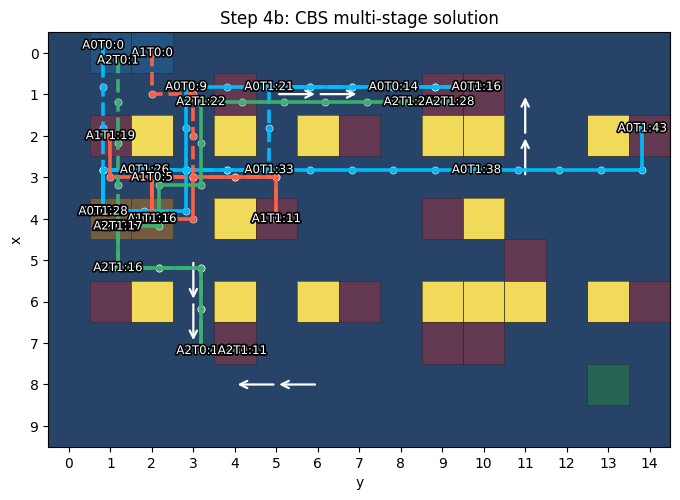

Saved GIF to: step4b_cbs_multi.gif


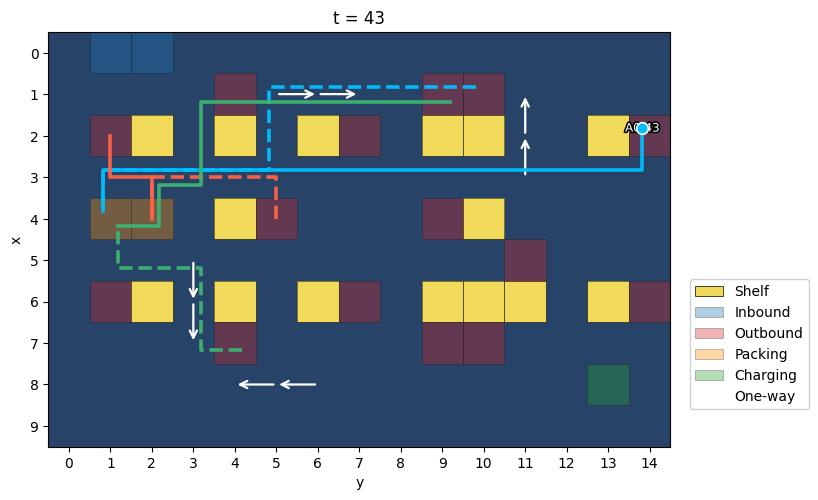

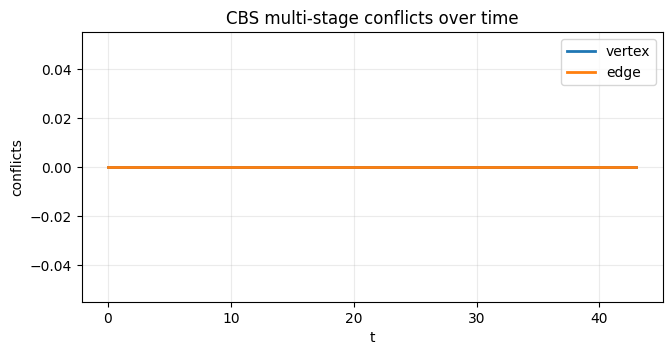

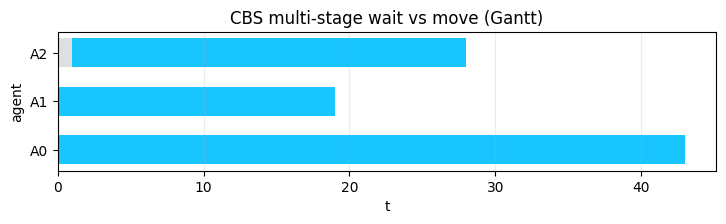

In [21]:
# Step 4b: multi-task CBS stress test with retries
enhanced_nonfl = make_enhanced_nonfl()
attempts = 6
tasks_cbs_multi = None
cbs_multi_result = None
best_partial_multi = None
best_partial_tasks = None

for i in range(attempts):
    seed = 50 + i
    candidate_tasks = sample_zone_tasks(
        enhanced_nonfl,
        k=3,
        seed=seed,
        tasks_per_agent=2,
    )
    try:
        candidate_result = run_cbs(
            candidate_tasks,
            nonfl=enhanced_nonfl,
            t_max=256,
            cost_metric="soc",
            max_expansions=30000,
            verbose=False,
        )
        tasks_cbs_multi = candidate_tasks
        cbs_multi_result = candidate_result
        print(f"[CBS-multi] Success with seed {seed} after {i+1} attempt(s).")
        break
    except CBSSearchError as exc:
        log_tail = exc.stats.get("log_tail", [])
        print(f"[CBS-multi] Attempt {i+1} failed (seed {seed}): {exc}")
        if log_tail:
            print("--- CBS debug log (tail) ---")
            for line in log_tail:
                print(line)
        if exc.best_result and (best_partial_multi is None or exc.best_result["cost"] < best_partial_multi["cost"]):
            best_partial_multi = exc.best_result
            best_partial_tasks = candidate_tasks

if cbs_multi_result is None:
    if best_partial_multi is None:
        raise RuntimeError("CBS multi-stage could not find a solution across attempted seeds.")
    print("[CBS-multi] Using best partial solution (may still have conflicts).")
    cbs_multi_result = best_partial_multi
    tasks_cbs_multi = best_partial_tasks
    timeline_partial = conflict_timeline(cbs_multi_result["paths"])
    residual_vertex = max(timeline_partial["vertex"]) if timeline_partial["vertex"] else 0
    residual_edge = max(timeline_partial["edge"]) if timeline_partial["edge"] else 0
    print(f"Remaining conflicts: vertex={residual_vertex}, edge={residual_edge}")
    sample_conf = list_conflicts(cbs_multi_result["paths"], limit=5)
    if sample_conf:
        print("Sample conflicts:")
        for ev in sample_conf:
            if ev["type"] == "vertex":
                print(f"  vertex t={ev['time']} cell={ev['cell']} agents={ev['agents']}")
            else:
                print(f"  edge   t={ev['time']} edge={ev['edge']} agents={ev['agents']}")

print("Multi-stage CBS tasks (per agent):")
for idx, seq in enumerate(tasks_cbs_multi):
    print(f"  Agent {idx}: {seq}")

for i in range(len(cbs_multi_result['paths'])):
  print(f"=== Agent {i} ===")
  print(cbs_multi_result['paths'][i])

print("Multi-stage CBS cost (SoC):", cbs_multi_result["cost"])
lengths_multi = [path_length(p) for p in cbs_multi_result["paths"]]
valid_multi = [l for l in lengths_multi if l is not None]
print("Agent path lengths:", lengths_multi, "| makespan =", max(valid_multi) if valid_multi else None)

plot_routes_unified(
    enhanced_nonfl,
    cbs_multi_result["segments"],
    title="Step 4b: CBS multi-stage solution",
    annotate_every=5,
)
animate_routes_unified_gif(
    enhanced_nonfl,
    cbs_multi_result["segments"],
    out_gif="step4b_cbs_multi.gif",
    fps=1,
    annotate_every=5,
)
timeline_multi = conflict_timeline(cbs_multi_result["paths"])
plot_conflict_timeline(timeline_multi, title="CBS multi-stage conflicts over time")
plot_wait_gantt(cbs_multi_result["paths"], title="CBS multi-stage wait vs move (Gantt)")


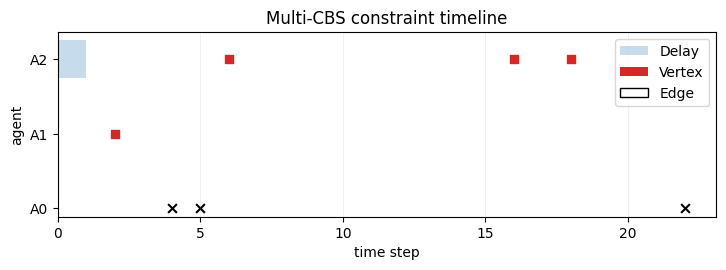

In [22]:
plot_constraint_timeline(cbs_multi_result.get('constraints', {}), title='Multi-CBS constraint timeline')